# Mass-Spring-Damper Systems
# Second Order in Time Systems with Damping and Periodic Forcing 
# Harmonic Balance vs. Time Integration

## Import Libraries

In [1]:
using LinearAlgebra
using NonlinearSolve
using DifferentialEquations
using FFTW

using BenchmarkTools

using Plots 

[ Info: Precompiling DifferentialEquations [0c46a032-eb83-5123-abaf-570d42b7fbaa]


## Section 1: Introduction  
 
Primary **goals** of this notebook include 

1. introduce the [harmonic balance method](https://en.wikipedia.org/wiki/Harmonic_balance) (a more intuitive introduction with examples would be nice to have) to approximate solutions of non-linear ordinary differential equations. This method will be introduced as an extension of the method of variation of constants for finding a particular solution for the non-homogeneous differential equation;

2. introduce the [NonlinearSolve.jl](https://docs.sciml.ai/NonlinearSolve/stable/) package to solve systems of non-linear algebraic equations resulting from the harmonic balance method. Analytical, numerical and symbolic methods to compute the Jacobian (derivative information) to be used within the Newton iteration (as search direction) will be explored.  

3. introduce the [DifferentialEquations.jl](https://docs.sciml.ai/DiffEqDocs/stable/) package to define initial value problems for second order differential equations and solve these problems numerically. We will use explicit and implicit time integration methods with an adaptively computed time-step for first order ODEs, second order ODEs and systems of first order ODEs. Examples of mass-spring and mass-spring-damper systems will be introduced. We wish to analyze the effect of damping, periodic forcing and the non-linearity of the equation. We will explore for to retrieve information from the solution data structure that DifferentialEquations.jl builds. 

4. introduce the the [Fast Fourier Transform](https://en.wikipedia.org/wiki/Fast_Fourier_transform) and the package [FFTW.jl](https://juliamath.github.io/FFTW.jl/stable/) to compute the Fourier transform of the solution obtained by time-integration (or to decompose a function varrying in time into cosine and sine basis functions). This serves two purposes. The first purpose is to compute the spectral content (dominant frequencies and corresponding amplitudes) of the solution obtained after time-integration. The second purpose is to obtain criteria to compare the time-integation and harmonic balance solutions. 

Secondary **goals** of this notebook include 
1. recap definitions and introduce notation that we employ in the remainder of the project;
2. introduce the <b>sympy</b> package as an additional tool for computations; 
3. introduce the celebrated <b>Duffing equation</b> as an example of a non-linear model with periodic forcing for which reference results are abundantly available in the literature; 

This notebook is structured into the following <b>four</b> parts: 
1. analysis of a linear mass-spring system oscillating endlessly without damping at its natural frequency; 
2. analysis of a linear mass-spring-damper system <b>without</b> periodic forcing oscillating at its natural frequency until the amplitude is negligably small; 
3. analysis of a linear mass-spring-damper system <b>with</b> periodic forcing oscillating oscillating at the frequency of the forcing (thus no longer the natural frequency) after initial effects have been cancelled;
4. analysis of a <b>non-linear</b> mass-spring-damper system with periodic forcing oscillating at a superposition of various frequencies. These frequencies include the frequency of the forcing (base frequency or fundamental frequency) and a set of integer multiples of this base frequency. More precise statements depend on the form of the non-linear term;  

To do: 
1. add references appropriate to the audience; 
2. review and fill-in various bits and pieces; 

##  Section 2:  Linear Mass-Spring System

Mass-spring model without damping and without external forcing. Assuming Hooke's linear relation betweeen force and displacement for the spring to hold. Assume non-zero initial position $u_0$ and non-zero initial velocity $v_0$. Then Newton's Law of motion results in the following initial value problem for second order ordinary differential equation 

$$
m \, \ddot{u}(t) + k \, u(t) = 0 \text{ supplied with }
u(t=0) = u_0 \text{ and } \dot{u}(t=0) = v_0 \, . 
$$

We rewrite the equation in canonical form (coeffient in front of $\ddot{u}(t)$ equal one) as $\ddot{u}(t) + \omega_0^2 \, u(t) = 0$, where $\omega_0 = \sqrt{k/m}$. 

Solve this homogeneous equation by solving first the characteristic equation. Then determine constants of integration using the initial conditions. Solution for $u(t)$ and $v(t)$ are  

$$
u(t) = u_0 \cos(\omega_0 \, t) + v_0 / \omega_0 \sin(\omega_0 \, t) \\
v(t) = - u_0 \, \omega_0 \, \sin(\omega_0 \, t) + v_0 \, \cos(\omega_0 \, t) \, . 
$$

Undamped oscillation occur at eigen (natural or proper) frequency $\omega_0$. For future reference, we rewrite the analytical solution as 
$u(t) = C \, \sin(\omega_0 \, t + \phi)$ where 
$C=\pm \sqrt{u_0^2+(v_0 / \omega_0)^2}$ (mind the physical dimensions) and $\phi = \arctan(v_0/(\omega_0 * u_0))$. FFT analysis show single peak at frequency $f_0 = \omega_0/(2*\pi)$ with peak value equal to $\sqrt{u_0^2+(v_0 / \omega_0)^2}$. 

To do: 
1. refer to symbolical solution using sympy.

### Define parameters 

In [2]:
#..set initial conditions for position (u0) and velocity (v0)
u0    = 0.1 # 0.1
v0    = 1.0 # 0.0   

#..set frequency and angular frequency 
freq = .5
om0  = 2 * π * freq 

#..set array p of parameters 
p = [om0, u0, v0]

#..compute the amplitude for u(t)
Campl = sqrt(u0^2+(v0/om0)^2)
# display("Campl = "); display(Campl)

#..set end time and time interval 
Tend = 100.0 
tspan = (0.0,Tend) 

(0.0, 100.0)

### Define analytical solution 

Note in Julia programming: observe the use of broadcast and of reduce(hcat,...) to transform a Vector of Vectors into an array.  

In [3]:
function u_anal(t,p)
    om0, u0, v0 = p 
    result = [-u0*om0*sin(om0*t) + v0*cos(om0*t), u0*cos(om0*t) + v0/om0*sin(om0*t)] 
    return result 
end 

u_anal (generic function with 1 method)

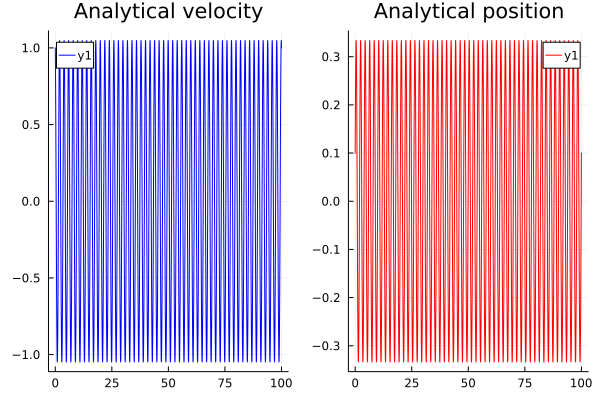

In [4]:
tvec   = Vector(0.:tspan[2]/10000:tspan[2])
result = u_anal.(tvec, Ref(p))
result = reduce(hcat,result)
p1 = plot(tvec, result[1,:],line = :blue,title="Analytical velocity") 
p2 = plot(tvec, result[2,:],line = :red,title="Analytical position") 
plot(p1,p2,layout=(1,2))

### Perform Time Integration and FFT analysis 

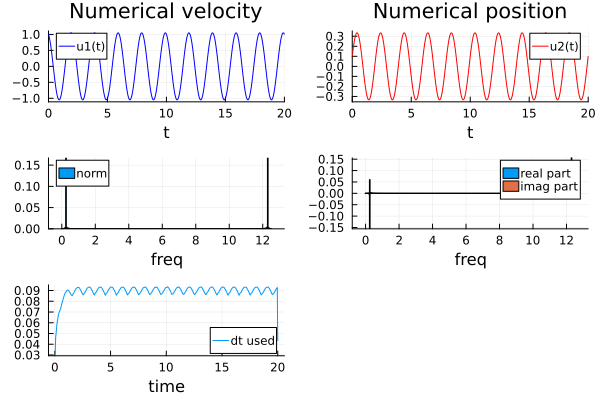

In [13]:
#..set rhs function of the ODE system 
function rhs(du,u,p,t)
    om0, u0, v0 = p 
    ddu = -om0^2*u
end 

#..set problem 
prob = SecondOrderODEProblem(rhs,v0,u0,tspan,p)

#..solve problem 
sol = solve(prob, AutoVern7(Rodas5()), reltol = 1e-8, abstol = 1e-8) 

# retrieve velocity and position at specific sampling points 
Tstart = 10 
Nsamples = 500
dt = Tend/Nsamples
tsampled = Vector(Tstart:dt:Tend)
vsampled = [sol(tk,idxs=1) for tk in tsampled] 
usampled = [sol(tk,idxs=2) for tk in tsampled]

# perform FFT of sampled position data and appropriately scale the result 
uf = fft(usampled); uf = 2.0/Nsamples * uf 

#..set frequency axis 
fmax = 1/(2.0*dt)
fstep = 2*fmax/Nsamples
fvec = Vector(0:fstep:fmax)

#..plot computed velocity and position in time  
p1 = plot(sol,idxs=1,line = :blue,title="Numerical velocity")
p2 = plot(sol,idxs=2,line = :red,title="Numerical position")
plot(p1,p2,layout = (1,2))

#..plot absolute value of FFT samples  
p3 = bar(fvec, abs.(uf[1:length(fvec)]),xlabel="freq",label="norm")
p4 = bar(fvec, real.(uf[1:length(fvec)]),xlabel="freq",label="real part")
p4 = bar!(fvec, imag.(uf[1:length(fvec)]),xlabel="freq",label="imag part") 

#..plot the time-step 
dt = sol.t[2:end] - sol.t[1:end-1]
p5 = plot(sol.t[2:end],dt,xlabel="time",label="dt used")

plot(p1,p2,p3, p4,p5, layout = (3,2))

### Compare Analytical and Numerical Approach 

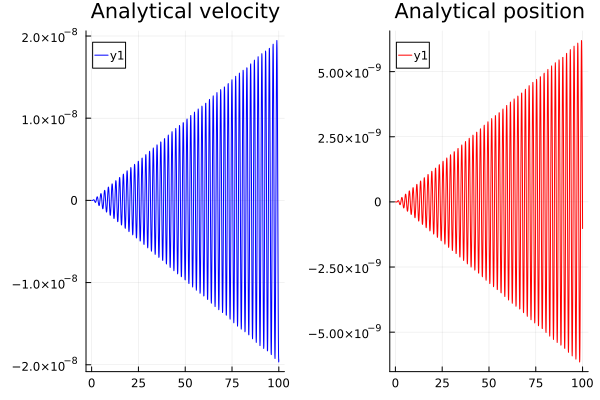

In [6]:
result = u_anal.(sol.t, Ref(p))
result = reduce(hcat,result)
vsampled = [sol(tk,idxs=1) for tk in sol.t] 
usampled = [sol(tk,idxs=2) for tk in sol.t]
p1 = plot(sol.t, result[1,:]-vsampled,line = :blue,title="Analytical velocity") 
p2 = plot(sol.t, result[2,:]-usampled,line = :red,title="Analytical position") 
plot(p1,p2,layout=(1,2))

### Exercises

1. explore the time integration in the time integration as a function of the absolute and relative tolerance imposed; 
2. compare explicit and implicit methods in the time integration (to do: provide more theory for students to understand this); 
3. compare second-order and first order coupled formulations in the time integration (do do: as above);
4. use the macro @btime to benchmark various runs in terms of memory usage and CPU time; 
5. observe in the FFT results, the shift peak location by changing frequency and the change in peak amplitude by changing the initial conditions;
6. extend to non-zero initial velocoity; 
7. make plots in the phase plane, see [this tutorial](https://docs.sciml.ai/DiffEqDocs/stable/examples/classical_physics/#Second-Order-Linear-ODE) as example; 

## Section 3: Linear Mass-Spring-Damper System without External Forcing

Linear model, no external forcing, non-zero initial position $u_0$, zero initial velocity. Initial value problem  

$$
m \, \ddot{u}(t) + \gamma \, \dot{u}(t)+ k \, u(t) = 0 \text{ supplied with }
u(t=0) = u_0 \text{ and } \dot{u}(t=0) = v_0 \, . 
$$

Equation in canonical form is 
$\ddot{u}(t) + \gamma/m \, \dot{u}(t)+ \omega_0^2 \, u(t) = 0$. 
Solve characteristic equation. Solution 
$u(t) = \exp(- \gamma / (2 \, m) \, t) [ u_0 \, \cos(\Omega_0 \, t) + v_0/\Omega_0 \, \sin(\Omega_0 \, t)]$. Damped oscillations. $u(t)$ approaches zero for long times. No oscillations after sufficiently long term.

Exercise: 
1. observe in the FFT results, the change in peak amplitude by changing the damping factor; 

To do: 
1. explain why numerical integration fails in case that damping factor is too large; 

### Define parameters

In [9]:
#..set initial conditions for position (u0) and velocity (v0)
u0    = 0.1 # 0.1
v0    = 1.0 # 0.0   

#..set frequency and angular frequency 
freq = .5
om0  = 2 * π * freq 
ga   = 1 # 0.5 
ma   = 1 

#..set array p of parameters 
p = [om0, ga, ma, u0, v0]

#..compute the amplitude for u(t)
Campl = sqrt(u0^2+(v0/om0)^2)
# display("Campl = "); display(Campl)

#..set end time and time interval 
Tend = 20.0 # 10.0 # 100.0 
tspan = (0.0,Tend) 

(0.0, 20.0)

### Define Analytical Solution 

In [10]:
function u_anal(t,p)
    om0, ga, ma, u0, v0 = p
    gascaled = ga/(2*ma)
    om = om0 - gascaled^2
    result = [exp(-gascaled*t)*(-u0*om0*sin(om0*t) + v0*cos(om0*t))-gascaled*exp(-gascaled*t)*(u0*cos(om*t) + v0/om0*sin(om*t)), 
              exp(-gascaled*t)*(u0*cos(om*t) + v0/om0*sin(om*t))] 
    return result 
end 

u_anal (generic function with 1 method)

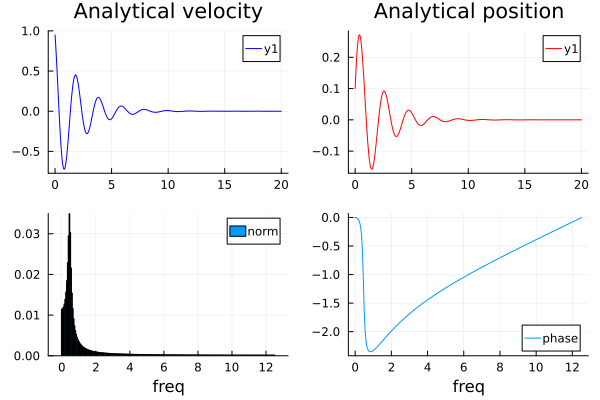

In [15]:
tvec   = Vector(0.:tspan[2]/10000:tspan[2])
result = u_anal.(tvec, Ref(p))
result = reduce(hcat,result)

# retrieve velocity and position at specific sampling points 
Nsamples = 500
Tstart = 20 
dt = Tend/Nsamples
tsampled = Vector(0:dt:Tend)
vsampled = [u_anal(tk,p)[1] for tk in tsampled] 
usampled = [u_anal(tk,p)[2] for tk in tsampled]

# perform FFT of sampled position data 
uf = fft(usampled);

#..set frequency axis 
fmax = 1/(2.0*dt)
fstep = 2*fmax/Nsamples
fvec = Vector(0:fstep:fmax)

p1 = plot(tsampled, vsampled,line = :blue,title="Analytical velocity") 
p2 = plot(tsampled, usampled,line = :red,title="Analytical position") 

#..plot absolute value of FFT samples  
p3 = bar(fvec, 2.0/Nsamples * abs.(uf[1:length(fvec)]),xlabel="freq",label="norm")
p4 = plot(fvec, angle.(uf[1:length(fvec)]),xlabel="freq",label="phase")

plot(p1,p2,p3, p4, layout = (2,2))

### Perform Numerical Time Integration 

Observe how in case of damping, the time step increases and error in computed solution decrases as the solution damps. 

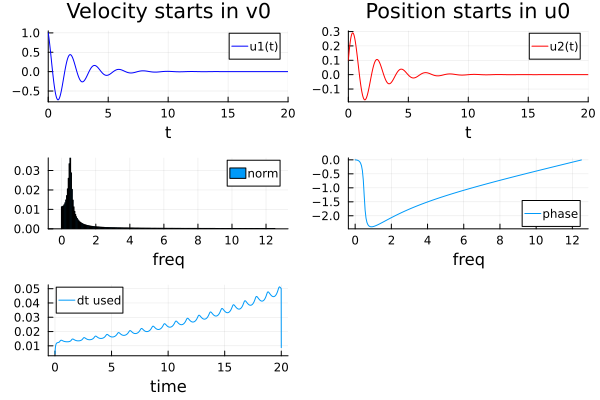

In [18]:
function rhs(du,u,p,t)
    om0, ga, ma, u0, v0 = p 
    ddu = -om0^2*u - ga/ma*du 
end

#..set problem 
prob = SecondOrderODEProblem(rhs,v0,u0,tspan,p)

#..solve problem 
sol = solve(prob, AutoVern7(Rodas5()), reltol = 1e-14, abstol = 1e-14) 

# retrieve velocity and position at specific sampling points 
Nsamples = 500
Tstart = 20 
dt = Tend/Nsamples
tsampled = Vector(0:dt:Tend)
vsampled = [sol(tk,idxs=1) for tk in tsampled] 
usampled = [sol(tk,idxs=2) for tk in tsampled]

# perform FFT of sampled position data 
uf = fft(usampled);

#..set frequency axis 
fmax = 1/(2.0*dt)
fstep = 2*fmax/Nsamples
fvec = Vector(0:fstep:fmax)

#..plot computed velocity and position in time  
p1 = plot(sol,idxs=1,line = :blue,title="Velocity starts in v0")
p2 = plot(sol,idxs=2,line = :red,title="Position starts in u0")
plot(p1,p2,layout = (1,2))

#..plot absolute value of FFT samples  
p3 = bar(fvec, 2.0/Nsamples * abs.(uf[1:length(fvec)]),xlabel="freq",label="norm")
p4 = plot(fvec, angle.(uf[1:length(fvec)]),xlabel="freq",label="phase")

#..plot the time-step 
dt = sol.t[2:end] - sol.t[1:end-1]
p5 = plot(sol.t[2:end],dt,xlabel="time",label="dt used")

plot(p1,p2,p3, p4,p5, layout = (3,2))

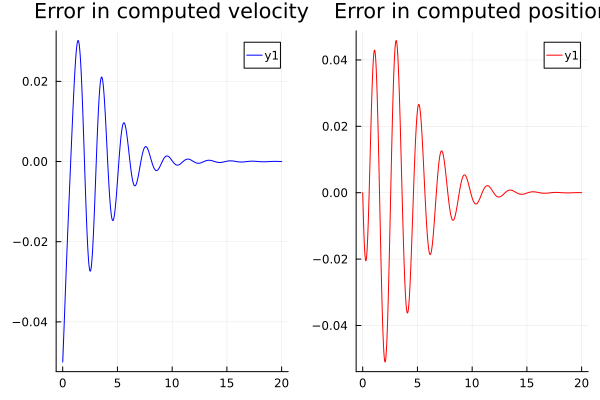

In [19]:
result = u_anal.(sol.t, Ref(p))
result = reduce(hcat,result)
vsampled = [sol(tk,idxs=1) for tk in sol.t] 
usampled = [sol(tk,idxs=2) for tk in sol.t]
p1 = plot(sol.t, result[1,:]-vsampled,line = :blue,title="Error in computed velocity") 
p2 = plot(sol.t, result[2,:]-usampled,line = :red,title="Error in computed position") 
plot(p1,p2,layout=(1,2))

## Section 4: Linear Mass-Spring-Damper System with External Forcing

<b>Goal</b>: find the amplitude of $u_p(t)$ analytically and compare with numerical computations.   

Linear model, non-zero initial position $u_0$, zero initial velocity. Equation 

$$ 
m \, \ddot{u}(t) + \gamma \, \dot{u}(t)+ k \, u(t) = F_0 \sin(\omega_d t)
\text{ supplied with }
u(t=0) = u_0 \text{ and } \dot{u}(t=0) = v_0 \, , 
$$

where $\omega_d$ denotes the driving frequency (thus not the eigenfrequency of the mass-spring-damper system). Solution $u(t) = u_h(t) + u_p(t)$ where method of method of variation of constants is used to find $u_p(t)$. Solve 2-by-2 linear system for amplitudes. After long time $u_h(t)=0$ and thus $u(t)=u_p(t)$. Oscillations at frequency $\omega_d$ after sufficiently long term.

Exercise: 
1. observe effect of changing $\omega_d$ and the adjustment of the time-step dt to the driving frequency; 

To do: 
1. compute analytically the amplitude of $u_p(t)$; 

"Campl = "

0.08133354389421515

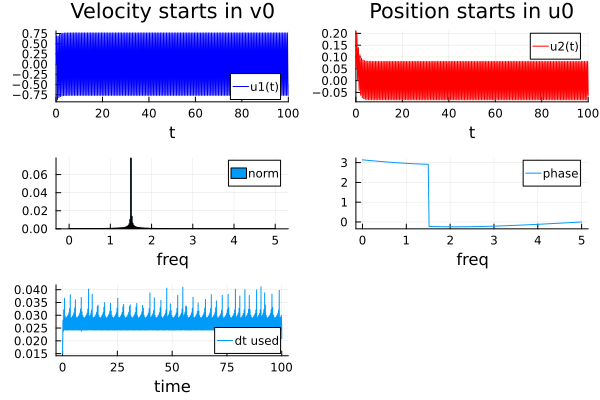

In [22]:
#..set initial conditions for position (u0) and velocity (v0)
u0    = 0.05
v0    = 0.0                        

#..set end time and time interval 
Tend = 100.0 
tspan = (0.0,Tend)  

#..set frequency and angular eigenfrequency and damping coeff
#..set drive amplitude and angular frequency
freq    = .5
omnul   = 2 * π * freq
gamma   = 10 # 10 
omdrive = 3*omnul # try also 10*omnul
Fampl   = 10 
mass    = 1

function rhs(du,u,p,t)
    ddu = -omnul^2*u - gamma*du + Fampl*sin(omdrive*t) 
end

#..compute the amplitude for u(t)
Campl = Fampl / sqrt(mass^2*(omnul^2-omdrive^2)^2+(gamma*omdrive)^2)
display("Campl = "); display(Campl)

#..set problem 
prob = SecondOrderODEProblem(rhs,v0,u0,tspan)

#..solve problem 
sol = solve(prob, AutoVern7(Rodas5()), reltol = 1e-8, abstol = 1e-8) 

# retrieve velocity and position at specific sampling points 
Nsamples = 500
Tstart = 50 # 20 
dt = (Tend-Tstart)/Nsamples
tsampled = Vector(Tstart:dt:Tend)
vsampled = [sol(tk,idxs=1) for tk in tsampled] 
usampled = [sol(tk,idxs=2) for tk in tsampled]

# perform FFT of sampled position data 
uf = fft(usampled);

#..set frequency axis 
fmax = 1/(2.0*dt)
fstep = 2*fmax/Nsamples
fvec = Vector(0:fstep:fmax)

#..plot computed velocity and position in time  
p1 = plot(sol,idxs=1,line = :blue,title="Velocity starts in v0")
p2 = plot(sol,idxs=2,line = :red,title="Position starts in u0")
plot(p1,p2,layout = (1,2))

#..plot absolute value of FFT samples  
p3 = bar(fvec, 2.0/Nsamples * abs.(uf[1:length(fvec)]),xlabel="freq",label="norm")
p4 = plot(fvec, angle.(uf[1:length(fvec)]),xlabel="freq",label="phase")

#..plot the time-step 
dt = sol.t[2:end] - sol.t[1:end-1]
p5 = plot(sol.t[2:end],dt,xlabel="time",label="dt used")

plot(p1,p2,p3, p4,p5, layout = (3,2))

## Section 5: Non-Linear Mass-Spring-Damper System with External Forces and Cubic Spring - Duffing Equation

Equation to solve 

$$ 
m \, \ddot{u}(t) + \gamma \, \dot{u}(t) + k_1 \, u(t) + k_3 \, u^3(t) = F_0 \sin(\omega_d t)
\text{ supplied with }
u(t=0) = u_0 \text{ and } \dot{u}(t=0) = v_0 \, , 
$$

Harmonic balance anzatz 

$$ 
u^{hb}(t) = A \cos(\omega_d t) + B \sin(\omega_d t) 
$$

where the amplitudes $A$ and $B$ are the solution of a non-linear. 

<b>Important</b> Explore values of $F_0$
1. $F_0$ small enough: linear regime, single frequency excitation, small time-step; 
2. $F_0$ large enough: non-linear regine, multiple frequency excitation, large time-step; 

To do: 
1. derive and solve 2-by-2 system for the cos and sin amplitude of the harmonic balance method. Three possible solutions; 3rd order polynomial; Bezout for number of possible solutions) system of algebraic equations; 
2. plot difference of solutions obtained by harmonic balancing and time integration; 

In [14]:
#..set initial conditions for position (u0) and velocity (v0)
u0    = 0.05
v0    = 0.0                        

#..set end time and time interval 
Tend = 20.0 # 100.0 
tspan = (0.0,Tend)               

#..set frequency and angular eigenfrequency and damping coeff
#..set drive amplitude and angular frequency
freq      = .5
omnul     = 2 * π * freq
gamma     = 10 
omdrive   = 3.5*omnul
Fampl     = 1000
mass      = 1
stiffnlin = 1e4
p         = [mass, omnul, omdrive, gamma, stiffnlin, Fampl]

# function for non-linear amplitudes A and B, taking parameters 
function  mismatch(x,p)
    A, B = x 
    m, om0, omd, ga, stiffnlin, F0 = p 
    mismathvec = zeros(2)
    mismathvec[1] = m*(om0^2-omd^2)*A + ga*omd*B + stiffnlin*.75*(A^3 + A*B^2) - F0
    mismathvec[2] = -ga*omd*A + m*(om0^2-omd^2)*B + stiffnlin*.75*(B^3 + A^2*B)
    return norm(mismathvec)^2 
end 

function rhs(du,u,p,t)
    ddu = -omnul^2*u - gamma*du + 1.0*Fampl*sin(omdrive*t) - stiffnlin*u^3
end

#..set problem 
prob = SecondOrderODEProblem(rhs,v0,u0,tspan)

#..solve problem 
sol = solve(prob, AutoVern7(Rodas5()), reltol = 1e-8, abstol = 1e-8) 

# retrieve velocity and position at specific sampling points 
Nsamples = 500
Tstart = 5 # 20 
dt = (Tend-Tstart)/Nsamples
tsampled = Vector(Tstart:dt:Tend)
vsampled = [sol(tk,idxs=1) for tk in tsampled] 
usampled = [sol(tk,idxs=2) for tk in tsampled]

# perform FFT of sampled position data 
uf = fft(usampled);

#..set frequency axis 
fmax = 1/(2.0*dt)
fstep = 2*fmax/Nsamples
fvec = Vector(0:fstep:fmax)

#..plot computed velocity and position in time  
p1 = plot(sol,idxs=1,line = :blue,title="Velocity starts in v0")
p2 = plot(sol,idxs=2,line = :red,title="Position starts in u0")


#..plot absolute value of FFT samples  
p3 = bar(fvec, 2.0/Nsamples * abs.(uf[1:length(fvec)]),xlabel="freq",label="norm")
p4 = plot(fvec, angle.(uf[1:length(fvec)]),xlabel="freq",label="phase")

#..plot the time-step 
dt = sol.t[2:end] - sol.t[1:end-1]
p5 = plot(sol.t[2:end],dt,xlabel="freq",label="dt used")

plot(p1,p2,p3, p4,p5, layout = (3,2))

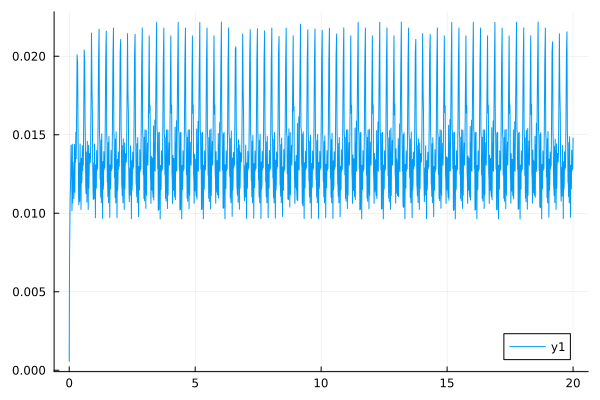

In [18]:
dt = sol.t[2:end] - sol.t[1:end-1]
plot(sol.t[2:end],dt)

┌ Warning: Backwards compatability support of the new return codes to Symbols will be deprecated with the Julia v1.9 release. Please see https://docs.sciml.ai/SciMLBase/stable/interfaces/Solutions/#retcodes for more information
└ @ SciMLBase ~/.julia/packages/SciMLBase/QqtZA/src/retcodes.jl:355


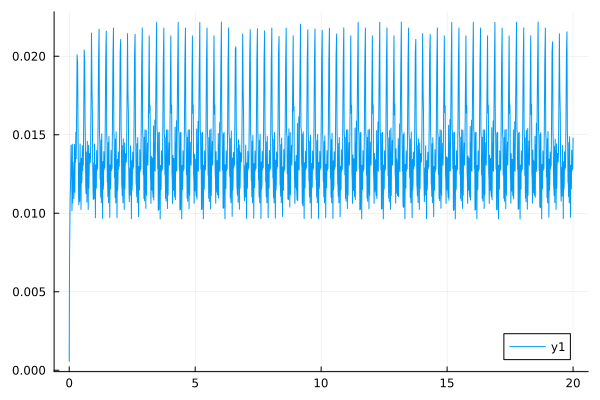

In [20]:
sol = solve(prob, Tsit5())
dt = sol.t[2:end] - sol.t[1:end-1]
plot(sol.t[2:end],dt)

In [23]:
prob_ss = SteadyStateProblem(prob)
sol = solve(prob_ss, DynamicSS(Tsit5()))

┌ Warning: Interrupted. Larger maxiters is needed. If you are using an integrator for non-stiff ODEs or an automatic switching algorithm (the default), you may want to consider using a method for stiff equations. See the solver pages for more details (e.g. https://docs.sciml.ai/DiffEqDocs/stable/solvers/ode_solve/#Stiff-Problems).
└ @ SciMLBase ~/.julia/packages/SciMLBase/QqtZA/src/integrator_interface.jl:504


u: (-6.741340294903215, 0.40784297832384087)

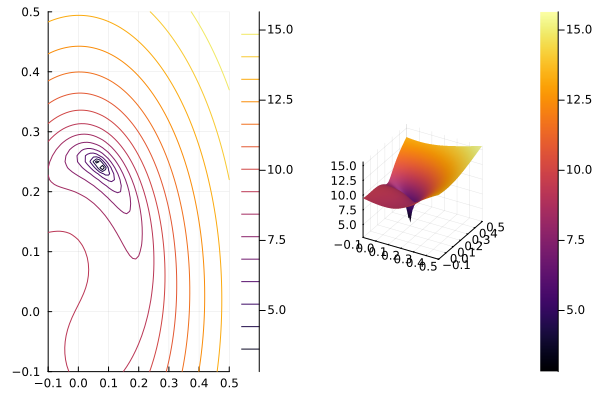

In [15]:
xvec = Vector(-.1:0.01:.5); yvec = copy(xvec)
X = [[xi, yj] for xi in xvec, yj in yvec]
M = mismatch.(X,Ref(p))
p1 = contour(xvec, yvec,log.(M)); p2 = surface(xvec,yvec,log.(M)) 
plot(p1,p2, layout=(1,2))

In [16]:
function  mismatch2(x,p)
    A, B = x 
    m, om0, omd, ga, stiffnlin, F0 = p 
    mismathvec = zeros(eltype(x),2)
    mismathvec[1] = m*(om0^2-omd^2)*A + ga*omd*B + stiffnlin*.75*(A^3 + A*B^2) - F0
    mismathvec[2] = -ga*omd*A + m*(om0^2-omd^2)*B + stiffnlin*.75*(B^3 + A^2*B)
    return mismathvec
end 

mismatch2 (generic function with 1 method)

In [17]:
prob = NonlinearProblem(mismatch2, [0.,0.], p)
solnl = solve(prob, NewtonRaphson())

┌ Warning: Backwards compatability support of the new return codes to Symbols will be deprecated with the Julia v1.9 release. Please see https://docs.sciml.ai/SciMLBase/stable/interfaces/Solutions/#retcodes for more information
└ @ SciMLBase ~/.julia/packages/SciMLBase/QqtZA/src/retcodes.jl:355


u: 2-element Vector{Float64}:
 0.24473426955609953
 0.07147514658531488

In [174]:
function u_hb(t,u,p)
    A, B = u 
    m, om0, omd, ga, stiffnlin, F0 = p
    result = A * cos(omd*t) + B * sin(omd*t)  
    return result 
end 

u_hb (generic function with 1 method)

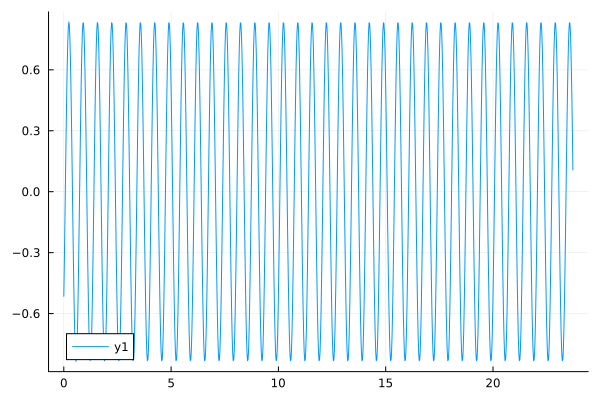

In [182]:
tvec = Vector(0.:tspan[2]/10000:tspan[2])
itend = 1000
plot(sol.t[1:itend], u_hb.(sol.t[1:itend],Ref(solnl.u), Ref(p)))

## Section 6: Implementation using HarmonicBalance.jl 

Explain four steps involved in implementing the above using the [HarmonicBalance.jl package](https://nonlinearoscillations.github.io/HarmonicBalance.jl/stable/); 


## Section 7: Possible Extensions

1. Extend to include a third order harmonic 
$u^{hb}(t) = A_1 \cos(\omega_d t) + B_1 \sin(\omega_d t) + A_3 \cos(3 \omega_d t) + B_3 \sin(3 \omega_d t)$. This is referred to as the <i>two-frequency ansartz</i> in the [HarmonicBalance.jl package](https://nonlinearoscillations.github.io/HarmonicBalance.jl/stable/); 

2. two coupled masses with positions $u_1(t)$ and $u_2(t)$ (and velocities $v_1(t)$ and $v_2(t)$). Write $u^{hb}(t) = [A_1 \cos(\omega_d t) + B_1 \sin(\omega_d t); A_2 \cos(\omega_d t) + B_2 \sin(\omega_d t)]$ (and similarly for $v^{hb}(t)$). This is referred to as the <i>two coupled oscillators</i> in the [HarmonicBalance.jl package](https://nonlinearoscillations.github.io/HarmonicBalance.jl/stable/); 

3. reformulate as a first order system 
$u^{hb}(t) = A \cos(\omega_d t) + B \sin(\omega_d t)$ and $v^{hb}(t) = C \cos(\omega_d t) + D \sin(\omega_d t)$. This is an intermediate step in solving the shallow water equations as a coupled system of first-order in time equations;    

## References 

1. Duffing equation: [wiki](https://en.wikipedia.org/wiki/Duffing_equation#CITEREFJordanSmith2007): provides details of harmonic balance method for single harmonic.  
2. Harmonic balance method applied to the Duffing equation: [youtube link](https://www.youtube.com/watch?v=4gCx4_RWeS8)
3. Asymptotic Expansions Applied to the Duffing Equation: [youtube link](https://www.youtube.com/watch?v=gxm2AzxfSII) 
4. bifurcartion analysis, eigenvalues of Jacobian, chaotic attractor for the Duffing equation: [Scholarpedia](http://scholarpedia.org/article/Duffing_oscillator)